Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

Ingestion

In [2]:
# Data
path = r"../data/raw/germanCredit.csv"
df_gc = pd.read_csv(path)
df = df_gc.copy()
df_gc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   checkin_acc        1000 non-null   object
 2   duration           1000 non-null   int64 
 3   credit_history     1000 non-null   object
 4   amount             1000 non-null   int64 
 5   savings_acc        1000 non-null   object
 6   present_emp_since  1000 non-null   object
 7   inst_rate          1000 non-null   int64 
 8   personal_status    1000 non-null   object
 9   residing_since     1000 non-null   int64 
 10  age                1000 non-null   int64 
 11  inst_plans         1000 non-null   object
 12  num_credits        1000 non-null   int64 
 13  job                1000 non-null   object
 14  status             1000 non-null   int64 
dtypes: int64(8), object(7)
memory usage: 117.3+ KB


Encoding

In [3]:
features_categorical = ['checkin_acc', 'credit_history',
       'savings_acc', 'present_emp_since', 'inst_rate', 'personal_status',
       'residing_since', 'inst_plans', 'num_credits', 'job',]

features_numerical = ['duration', 'amount', 'age',]

target = ['status']

with open("../bin/oneHotEncoder.bin", "rb") as f_in:
    enc = pickle.load(f_in)

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from src.featureEngineering import encode
X_en = encode(data = df,
              X_cat = features_categorical,
              X_num = features_numerical,
              encoder = enc)

Base Model - Linear Logistic Regression

In [13]:
import statsmodels.api as sm
X = sm.add_constant(X_en)
y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state=42)

import statsmodels.api as sm
model = sm.Logit(y_train, X_train)
clf_log = model.fit()
print( clf_log.summary2() ) 

Optimization terminated successfully.
         Current function value: 0.483041
         Iterations 13
                                    Results: Logit
Model:                      Logit                   Method:                  MLE       
Dependent Variable:         status                  Pseudo R-squared:        0.208     
Date:                       2023-06-21 18:08        AIC:                     748.2578  
No. Observations:           700                     BIC:                     912.0967  
Df Model:                   35                      Log-Likelihood:          -338.13   
Df Residuals:               664                     LL-Null:                 -426.75   
Converged:                  1.0000                  LLR p-value:             6.3193e-21
No. Iterations:             13.0000                 Scale:                   1.0000    
---------------------------------------------------------------------------------------
                       Coef.     Std.Err.      z    P>

In [16]:
model_diagnostics = pd.DataFrame({
                                    'FEATURES' : ['Bias'] + list(X_en.columns),
                                    'PVALUES'  : clf_log.pvalues,
                                }).set_index('FEATURES')

model_diagnostics.sort_values(by='PVALUES',ascending=True)[:10]

,PVALUES
FEATURES,
personal_status_A94,0.000000
amount,0.025358
duration,0.040088
age,0.054068
savings_acc_A64,1.000000
savings_acc_A61,1.000000
credit_history_A34,1.000000
savings_acc_A62,1.000000
credit_history_A31,1.000000


In [21]:
# Metrics
def binary_metrics(df):
    from sklearn import metrics
    cm = metrics.confusion_matrix(df['Y_TEST'], df['Y_PRED'], labels=[1,0]);

    TP, FP, TN, FN = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    SENSITIVITY = np.round(  TP / ( TP + FN ), 2 )
    SPECIFICITY = np.round(  TN / ( TN + FP ), 2 )
    PRECESION   = np.round(  TP / ( TP + FP ), 2 )
    print( 'SENSITIVITY =', np.round(  TP / ( TP + FN ), 2 ))
    print( 'SPECIFICITY =', np.round(  TN / ( TN + FP ), 2 ))
    print( 'PRECESION   =', np.round(  TP / ( TP + FP ), 2 ))
    print( 'F_SCORE     =', np.round(  2 * SENSITIVITY * PRECESION / (SENSITIVITY + PRECESION), 2))
    print( '---------------CLASSIFICATION REPORT---------------' )
    print( metrics.classification_report(df['Y_TEST'], df['Y_PRED']) )

    # Plots
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, 
                                        sharex=False, figsize=(20, 5));

    # Confusion Matrix
    sns.heatmap(cm,
                annot=True,
                fmt='.0f',
                xticklabels=['POSITIVE' , 'NEGATIVE'],
                yticklabels=['POSITIVE' , 'NEGATIVE'],
                ax=ax0
                );
    ax0.set_ylabel('True label');
    ax0.set_xlabel('Predicted label');


    # Overlap Plots
    sns.histplot(df[df['Y_TEST'] == 1]['Y_PROB'],
                kde = True,
                color = 'b',
                label = 'BAD CREDIT',
                bins  = 20,
                ax=ax1 );

    sns.histplot(df[df['Y_TEST'] == 0]['Y_PROB'],
                kde = True,
                color = 'k',
                label = 'GOOD CREDIT',
                bins  = 20,
                ax=ax1 );

    # ROC AUC Curve
    fpr, tpr, thresholds = metrics.roc_curve(df['Y_TEST'],
                                             df['Y_PROB'],
                                             drop_intermediate=False,
                                            );

    sns.lineplot(x=fpr, 
                y=tpr,
                label = 'ROC Curve = %0.2f' %metrics.roc_auc_score(df['Y_TEST'], df['Y_PROB']),
                ax=ax2    
                );
    plt.plot([0,1],[0,1], 'k--'); plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05]);
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(), plt.show();

SENSITIVITY = 0.44
SPECIFICITY = 0.92
PRECESION   = 0.71
F_SCORE     = 0.54
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       209
           1       0.71      0.44      0.54        91

    accuracy                           0.78       300
   macro avg       0.75      0.68      0.70       300
weighted avg       0.77      0.78      0.76       300



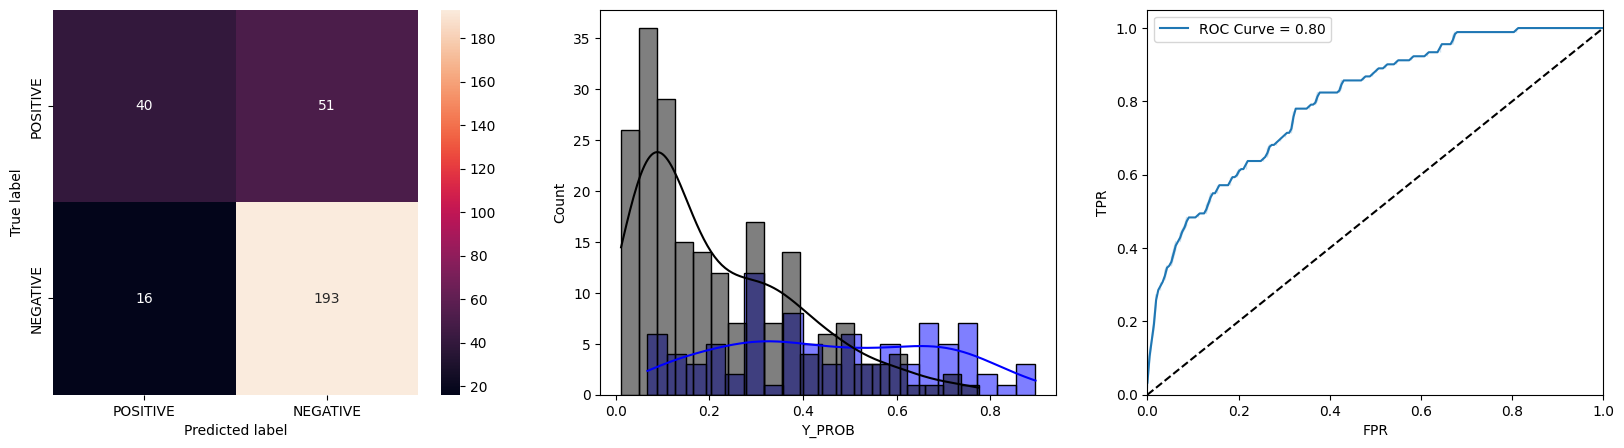

In [22]:
binary_metrics(df=model2Predictions)

In [36]:
import pickle
with open('../bin/clf_log1.bin', 'wb') as f_out:
    pickle.dump(clf_log, f_out)

Significant Variables

In [29]:
significant_variables = ['checkin_acc_A14', 'credit_history_A34', 'inst_rate_1', 'amount', 'age', 'savings_acc_A65', 'checkin_acc_A13', 'duration' ]

In [31]:
import statsmodels.api as sm
X = sm.add_constant(X_en[significant_variables])
y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state=42)

import statsmodels.api as sm
model = sm.Logit(y_train, X_train)
clf_log2 = model.fit()
print( clf_log2.summary2() ) 

Optimization terminated successfully.
         Current function value: 0.515630
         Iterations 6
                          Results: Logit
Model:               Logit            Method:           MLE       
Dependent Variable:  status           Pseudo R-squared: 0.154     
Date:                2023-06-21 18:21 AIC:              739.8821  
No. Observations:    700              BIC:              780.8418  
Df Model:            8                Log-Likelihood:   -360.94   
Df Residuals:        691              LL-Null:          -426.75   
Converged:           1.0000           LLR p-value:      1.3013e-24
No. Iterations:      6.0000           Scale:            1.0000    
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -0.0151   0.3549 -0.0425 0.9661 -0.7108  0.6805
checkin_acc_A14    -1.5255   0.2177 -7.0077 0.0000 -1

In [34]:
model2Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': clf_log2.predict(X_test).tolist(),                       
                                })
model2Predictions['Y_PRED'] = model2Predictions['Y_PROB'].map( lambda x: 1 if x> 0.5 else 0)

SENSITIVITY = 0.31
SPECIFICITY = 0.89
PRECESION   = 0.55
F_SCORE     = 0.4
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       209
           1       0.55      0.31      0.39        91

    accuracy                           0.71       300
   macro avg       0.65      0.60      0.60       300
weighted avg       0.69      0.71      0.69       300



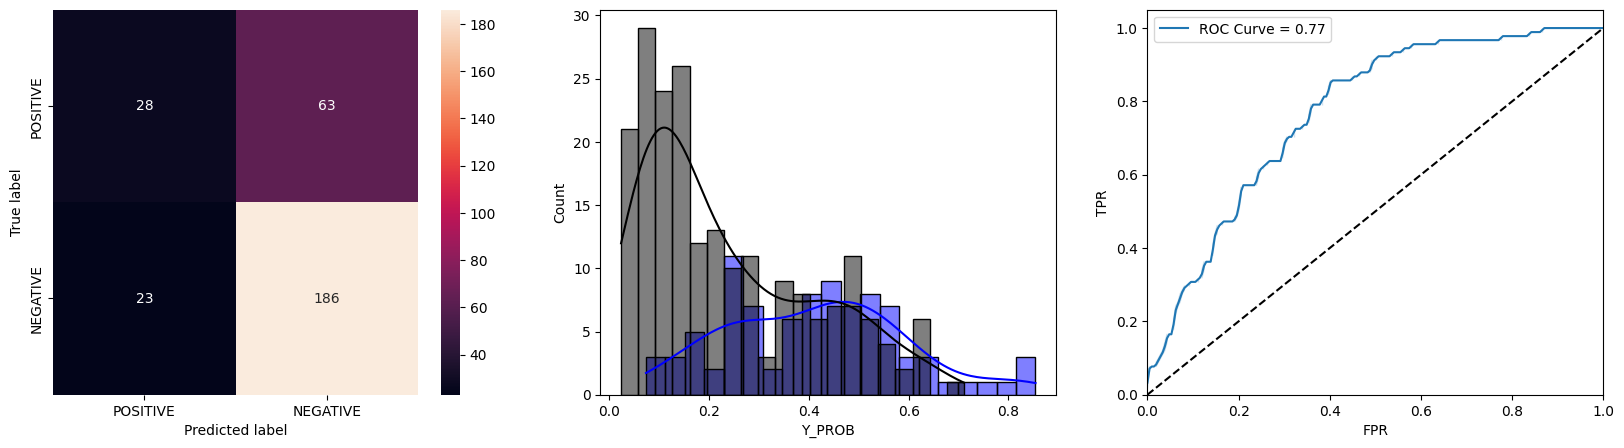

In [35]:
binary_metrics(df=model2Predictions)

# Model 3 Youden's Index
Changes Threshold from 0.5 to 0.22 on same model

In [41]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(model2Predictions['Y_TEST'],
                                         model2Predictions['Y_PROB'],
                                            drop_intermediate=False,
                                        )

In [42]:
df_tpr_fpr = pd.DataFrame({
                            'TPR' : tpr,
                            'FPR' : fpr,
                            'THR' : thresholds,
})
df_tpr_fpr['DIFF'] = df_tpr_fpr['TPR'] - df_tpr_fpr['FPR']
df_tpr_fpr.sort_values('DIFF', 
                      ascending = False,
                      ).head()

,TPR,FPR,THR,DIFF
160,0.846154,0.397129,0.221534,0.449025
161,0.846154,0.401914,0.216531,0.444240
162,0.846154,0.406699,0.215591,0.439455
159,0.835165,0.397129,0.223980,0.438036
166,0.857143,0.421053,0.207107,0.436090


In [43]:
model3Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': model_log.predict(X_test).tolist(),                       
                                })
model3Predictions['Y_PRED'] = model3Predictions['Y_PROB'].map( lambda x: 1 if x> 0.22 else 0)
model3Predictions.head()

,Y_TEST,Y_PROB,Y_PRED
521,1,0.452449,1
737,0,0.491820,1
740,0,0.418416,1
660,0,0.270285,1
411,0,0.132119,0


SENSITIVITY = 0.85
SPECIFICITY = 0.6
PRECESION   = 0.48
F_SCORE     = 0.61
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       209
           1       0.48      0.85      0.61        91

    accuracy                           0.68       300
   macro avg       0.69      0.72      0.67       300
weighted avg       0.77      0.68      0.69       300



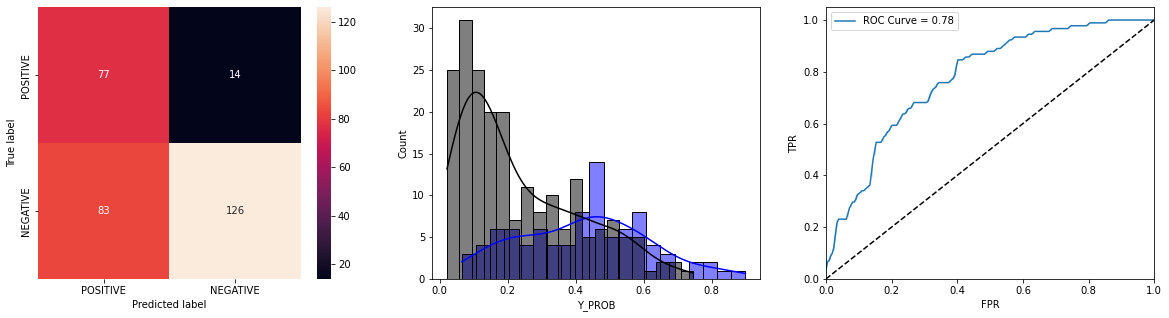

In [44]:
binary_metrics(model3Predictions)

# Model 4 Cost-based Approach
Changes threshold from 0.22 to 0.14 for same Model 2

In [45]:
def gettotalcost(Y_TEST, Y_PRED, COST_FP, COST_FN ):
    cm = metrics.confusion_matrix( Y_TEST, Y_PRED, labels=[1,0])
    cm_mat = np.array( cm )
    return cm_mat[0,1] * COST_FN + cm_mat[1,0] * COST_FP

df_cost = pd.DataFrame(columns = ['Prob', 'Cost'])

idx = 0
for each_prob in range(10, 50):
    cost = gettotalcost(Y_TEST  = model3Predictions['Y_TEST'],
                        Y_PRED  = model3Predictions['Y_PROB'].map( lambda x: 1 if x > (each_prob/100) else 0), 
                        COST_FP = 1, 
                        COST_FN = 5,
                        )
    df_cost.loc[idx] = [each_prob / 100 , cost]
    idx = idx + 1


In [46]:
df_cost.sort_values('Cost', ascending=True)[:10]

,Prob,Cost
4,0.14,150.0
12,0.22,153.0
2,0.12,154.0
10,0.20,154.0
9,0.19,156.0
5,0.15,156.0
6,0.16,157.0
11,0.21,157.0
3,0.13,158.0
7,0.17,158.0


In [47]:
model4Predictions = pd.DataFrame({
                                    'Y_TEST': y_test['status'],
                                    'Y_PROB': model_log.predict(X_test).tolist(),                       
                                })
model4Predictions['Y_PRED'] = model4Predictions['Y_PROB'].map( lambda x: 1 if x> 0.14 else 0)
model4Predictions.head()

,Y_TEST,Y_PROB,Y_PRED
521,1,0.452449,1
737,0,0.491820,1
740,0,0.418416,1
660,0,0.270285,1
411,0,0.132119,0


SENSITIVITY = 0.93
SPECIFICITY = 0.43
PRECESION   = 0.41
F_SCORE     = 0.57
---------------CLASSIFICATION REPORT---------------
              precision    recall  f1-score   support

           0       0.94      0.43      0.59       209
           1       0.41      0.93      0.57        91

    accuracy                           0.58       300
   macro avg       0.68      0.68      0.58       300
weighted avg       0.78      0.58      0.58       300



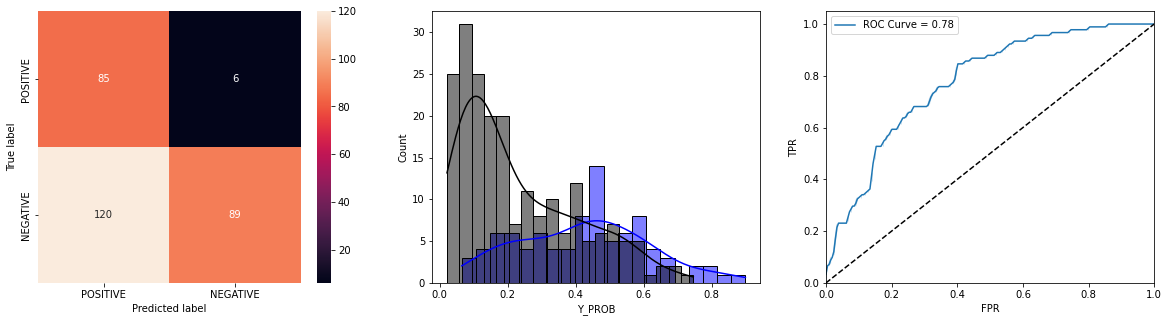

In [48]:
binary_metrics(model4Predictions)